# Stable Diffusion on a GPU

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bacalhau-project/examples/blob/main/model-inference/stable-diffusion-gpu/index.ipynb)
[![Open In Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/bacalhau-project/examples/HEAD?labpath=model-inference/stable-diffusion-gpu/index.ipynb)

This example tutorial demonstrates how to use stable diffusion on a GPU and run it on the [Bacalhau](https://www.bacalhau.org/) network.[Stable Diffusion](https://github.com/CompVis/stable-diffusion) is a state of the art text-to-image model that generates images from text and was developed as an open source alternative to [DALL·E 2](https://openai.com/dall-e-2/). It is based on a [Diffusion Probabilistic Model](https://arxiv.org/abs/2102.09672) and uses a [Transformer](https://arxiv.org/abs/1706.03762) to generate images from text. 

## Prerequisite

To get started, you need to install the Bacalhau client, see more information [here](https://docs.bacalhau.org/getting-started/installation)

### Quick Test

Here is an example of an image generated by this model.

```bash
bacalhau docker run --gpu 1 ghcr.io/bacalhau-project/examples/stable-diffusion-gpu:0.0.1 -- python main.py --o ./outputs --p "cod swimming through data"
```
![](./image0.png)

## Development

This stable diffusion example is based on the [Keras/Tensorflow implementation](https://github.com/fchollet/stable-diffusion-tensorflow). You might also be interested in the Pytorch oriented [diffusers library](https://github.com/huggingface/diffusers).

### Installing dependencies

:::info
When you run this code for the first time, it will download the pretrained weights, which may add a short delay.
:::

Based on the requirements [here](https://github.com/fchollet/stable-diffusion-tensorflow), we will install the following:

In [ ]:
%%bash
pip install git+https://github.com/fchollet/stable-diffusion-tensorflow --upgrade --quiet
pip install tensorflow tensorflow_addons ftfy --upgrade --quiet
pip install tqdm
apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

### Testing the Code

We have a sample code from this the [Stable Diffusion in TensorFlow/Keras](https://github.com/fchollet/stable-diffusion-tensorflow) repo which we will use to check if the code is working as expected. Our output for this code will be a _DSLR photograph of an astronaut riding a horse_.

:::tip
When you run this code for the first time, it will download the pretrained weights, which may add a short delay.
:::

In [ ]:
from stable_diffusion_tf.stable_diffusion import Text2Image
from PIL import Image

generator = Text2Image( 
    img_height=512,
    img_width=512,
    jit_compile=False,  # You can try True as well (different performance profile)
)
img = generator.generate(
    "DSLR photograph of an astronaut riding a horse",
    num_steps=50,
    unconditional_guidance_scale=7.5,
    temperature=1,
    batch_size=1,
)
pil_img = Image.fromarray(img[0])
display(pil_img)

When running this code, if you check the GPU RAM usage, you'll see that it's sucked up many GBs and depending on what GPU you're running, it may OOM(Out of memory) if you run this again.

You can try and reduce RAM usage by playing with batch sizes (although it is only set to 1 above!) or more carefully controlling the tensorflow session.

To clear the GPU memory we will use **numba**. This won't be required when running in a single-shot manner.

In [ ]:
%%bash
pip install numba

In [6]:
# clearing the GPU memory 
from numba import cuda 
device = cuda.get_current_device()
device.reset()

### Write the Script

You need a script to execute when we submitting jobs. The code below is a slightly modified version of the code we ran above which we got from [here](https://github.com/fchollet/stable-diffusion-tensorflow), however this includes more things such as argument parsing [argument parsing](https://github.com/fchollet/stable-diffusion-tensorflow/blob/master/text2image.py) to be able to customize the generator.

In [ ]:
%%writefile main.py
import argparse
from stable_diffusion_tf.stable_diffusion import Text2Image
from PIL import Image
import os
parser = argparse.ArgumentParser(description="Stable Diffusion")
parser.add_argument("--h",dest="height", type=int,help="height of the image",default=512)
parser.add_argument("--w",dest="width", type=int,help="width of the image",default=512)
parser.add_argument("--p",dest="prompt", type=str,help="Description of the image you want to generate",default="cat")
parser.add_argument("--n",dest="numSteps", type=int,help="Number of Steps",default=50)
parser.add_argument("--u",dest="unconditionalGuidanceScale", type=float,help="Number of Steps",default=7.5)
parser.add_argument("--t",dest="temperature", type=int,help="Number of Steps",default=1)
parser.add_argument("--b",dest="batchSize", type=int,help="Number of Images",default=1)
parser.add_argument("--o",dest="output", type=str,help="Output Folder where to store the Image",default="./")

args=parser.parse_args()
height=args.height
width=args.width
prompt=args.prompt
numSteps=args.numSteps
unconditionalGuidanceScale=args.unconditionalGuidanceScale
temperature=args.temperature
batchSize=args.batchSize
output=args.output

generator = Text2Image(
    img_height=height,
    img_width=width,
    jit_compile=False,  # You can try True as well (different performance profile)
)

img = generator.generate(
    prompt,
    num_steps=numSteps,
    unconditional_guidance_scale=unconditionalGuidanceScale,
    temperature=temperature,
    batch_size=batchSize,
)
for i in range(0,batchSize):
  pil_img = Image.fromarray(img[i])
  image = pil_img.save(f"{output}/image{i}.png")


:::info
For a full list of arguments that you can pass to the script, see more information [here](https://docs.bacalhau.org/all-flags)
:::

### Run the Script
After writing the code the next step is to run the script.

In [ ]:
%%bash
python main.py

### Display the Output Image

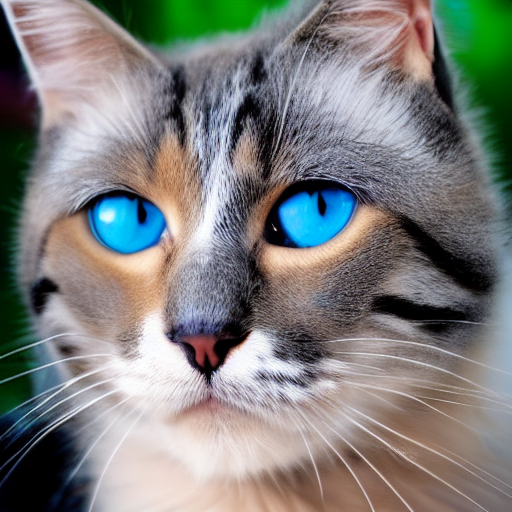

In [9]:
import IPython.display as display
display.Image("image0.png")

The following presents additional parameters you can try:

- `python main.py --p "cat with three eyes`  - to set prompt

- `python main.py --p "cat with three eyes` --n 100 - to set number of iterations to 100

-  `python stable-diffusion.py --p "cat with three eyes" --b 2` to set batch size to 2 (No of images to generate)


## Containerize your Script using Docker

Docker is the easiest way to run TensorFlow on a GPU since the host machine only requires the [NVIDIA® driver](https://github.com/NVIDIA/nvidia-docker/wiki/Frequently-Asked-Questions#how-do-i-install-the-nvidia-driver). To containerize the inference code, we we will create a `Dockerfile`. The Dockerfile is a text document that contains the commands that specify how the image will be built.

```Dockerfile
FROM tensorflow/tensorflow:2.10.0-gpu

RUN apt-get -y update

RUN apt-get -y install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 git

RUN python3 -m pip install --upgrade pip

RUN python -m pip install regex tqdm Pillow tensorflow tensorflow_addons ftfy  --upgrade --quiet

RUN pip install git+https://github.com/fchollet/stable-diffusion-tensorflow --upgrade --quiet

ADD main.py main.py

# Run once so it downloads and caches the pre-trained weights
RUN python main.py --n 1
```

The dockerfile leverages the latest official tensorflow GPU image and then installs other dependencies like `git`, `CUDA` packages and other image related necessities. See [the original repository](https://github.com/fchollet/stable-diffusion-tensorflow/blob/master/requirements.txt) for the expected requirements.


### Build the container

The `docker build` command builds Docker images from a Dockerfile. 

```
docker build -t <hub-user>/<repo-name>:<tag> .
```

Before running the command replace;

- **hub-user** with your docker hub username, If you don’t have a docker hub account [follow these instructions to create docker account](https://docs.docker.com/docker-id/), and use the username of the account you created

- **repo-name** with the name of the container, you can name it anything you want

- **tag** this is not required but you can use the latest tag

In our case

```bash
docker build -t ghcr.io/bacalhau-project/examples/stable-diffusion-gpu:0.0.1 .
```

### Push the container

Next, upload the image to the registry. This can be done by using the Docker hub username, repo name or tag.

```
docker push <hub-user>/<repo-name>:<tag>
```

## Running a Bacalhau Job to Generate an Image 

After the repo image has been pushed to docker hub, we can now use the container for running on Bacalhau. To submit a job, run the following Bacalhau command:

In [25]:
%%bash --out job_id
bacalhau docker run --id-only --gpu 1 ghcr.io/bacalhau-project/examples/stable-diffusion-gpu:0.0.1 -- python main.py --o ./outputs --p "meme about tensorflow"

When a job is sumbitted, Bacalhau prints out the related `job_id`. We store that in an environment variable so that we can reuse it later on.

In [ ]:
%%env JOB_ID={job_id}

The Bacalhau command passes a prompt to the model and generates an image in the outputs directory. The main difference in the example below compared to all the other examples is the addition of the `--gpu X` flag, which tells Bacalhau to only schedule the job on nodes that have `X` GPUs free. You can [read more about GPU support](https://docs.bacalhau.org/running-node/gpu/#gpu-node-configuration) in the documentation. 

:::tip
This will take about 5 minutes to complete and is mainly due to the cold-start GPU setup time. This is faster than the CPU version, but you might still want to grab some fruit or plan your lunchtime run.

Furthermore, the container itself is about 10GB, so it might take a while to download on the node if it isn't cached.
:::

## Checking the State of your Jobs

- **Job status**: You can check the status of the job using `bacalhau list`. 

In [ ]:
%%bash
bacalhau list --id-filter ${JOB_ID}

When it says `Completed`, that means the job is done, and we can get the results.

- **Job information**: You can find out more information about your job by using `bacalhau describe`.

In [ ]:
%%bash
bacalhau describe ${JOB_ID}

- **Job download**: You can download your job results directly by using `bacalhau get`. Alternatively, you can choose to create a directory to store your results. In the command below, we created a directory and downloaded our job output to be stored in that directory.

In [ ]:
%%bash
rm -rf results && mkdir -p results
bacalhau get $JOB_ID --output-dir results

After the download has finished you should see the following contents in results directory

## Viewing your Job Output

Each job creates 3 subfolders: the **combined_results**, **per_shard files**, and the **raw** directory. To view the file, run the following command:

In [ ]:
%%bash
ls results/combined_results/outputs

### Display image

To display and view your image run the code below:

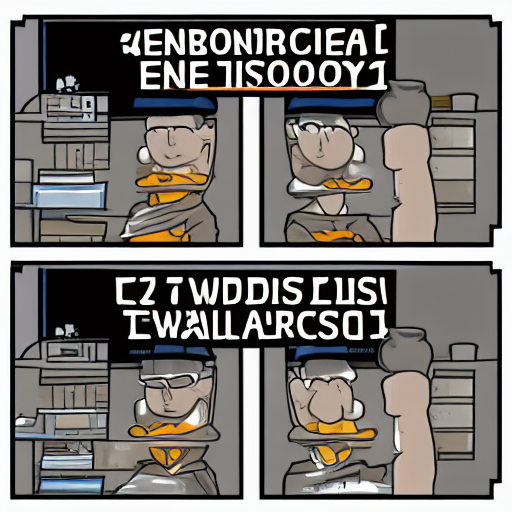

In [31]:
import IPython.display as display
display.Image("results/combined_results/outputs/image0.png")